These characteristics (make, model, year, etc.) are what we call features. The price is our target—the thing we want to predict. Because our target is a number (price), this is a regression problem.

Our Game Plan
Get the Data: First, we'll download our car dataset.

Explore and Investigate: Before building anything, we'll poke around the data to see what stories it tells.

Prepare for Validation: We'll carefully split our data to ensure we can trust our model's predictions on new, unseen cars.

Build the Model: This is the fun part! We'll code the linear regression algorithm ourselves.

Improve the Features: We'll tweak and prepare our data to help the model make better predictions.

Finalize and Predict: We'll apply regularization to create a robust, reliable model and then put it to the test.

In [ ]:
import numpy as np # numpy for numerical operations
import pandas as pd # pandas for tabular data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv("data.csv")

# Explotary data analysis

Our first discovery is that the dataset contains information on nearly 12,000 different cars—a great starting point. A quick glance at the data reveals some common real-world messiness: inconsistent capitalization and spacing in the text. We clean this up by making everything lowercase and replacing spaces with underscores, ensuring consistency for the model.

In [ ]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [ ]:
len(df)

11914

In [ ]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [ ]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


The dataset includes various columns like the car’s make, model, year, engine specs, transmission type, fuel efficiency, and even a popularity score. But the most important column is MSRP—the manufacturer’s suggested retail price. This is our target: the value we’ll train our model to predict using all the other information as clues.

The plot immediately reveals something crucial: our data has a "long tail" distribution. This means that while most cars are clustered at the lower end of the price spectrum (the "head"), there are a handful of extremely expensive luxury or exotic cars that create a very long, thin "tail" stretching out to the right.



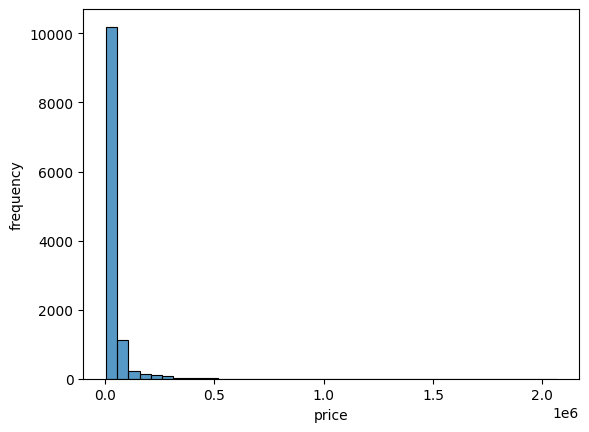

In [ ]:
# Create the histogram
sns.histplot(df.msrp, bins=40)

# Set labels using matplotlib
plt.xlabel('price')
plt.ylabel('frequency')
plt.show()

Visual checks of the target (msrp) distribution — first full range, then zoom to values < $100k to inspect the main bulk of the data.

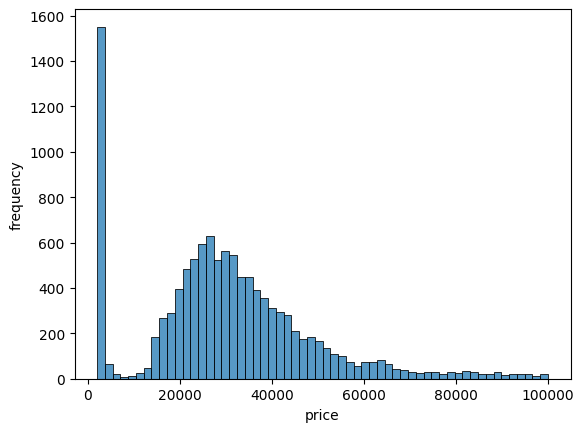

In [ ]:
 sns.histplot(df.msrp[df.msrp < 100000])
 plt.xlabel('price')
plt.ylabel('frequency')
plt.show()

This long tail is problematic. It's hard to see the details of where most cars are priced, and more importantly, it can severely confuse a machine learning model. The model might become obsessed with trying to predict those few ultra-expensive cars correctly at the expense of accurately pricing the vast majority of vehicles. To solve this, we use a clever mathematical trick called a log transformation.

In [ ]:
log_price = np.log1p(df.msrp)


<Axes: xlabel='msrp', ylabel='Count'>

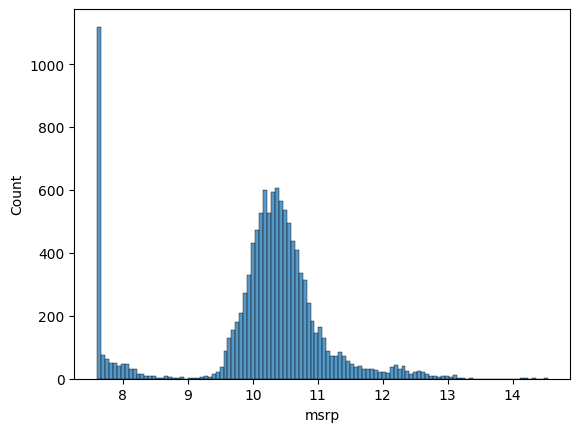

In [ ]:
sns.histplot(log_price)

# Checking for missing values

So, our next task is to scan through our dataset to see if any values are missing. This will tell us if we need to take extra steps to clean and prepare our data before we can use it to build our price prediction model.



In [ ]:
df.isnull().sum()

,0
make,0
model,0
year,0
engine_fuel_type,3
engine_hp,69
engine_cylinders,30
transmission_type,0
driven_wheels,0
number_of_doors,6
market_category,3742


# Splitting data into Train - Valid - Test sets

In [ ]:
n = len(df)
print(n)

11914


Calculate how many rows go into train/validation/test given 60/20/20 split (works for any n).

In [ ]:
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
print(n_val)
print(n_test)
print(n_train)

2382
2382
7150


Fix the RNG seed for reproducibility, create a shuffled index array, and use it to shuffle the DataFrame.

In [ ]:
np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

In [ ]:
df_shuffled = df.iloc[idx]

# Split shuffled DataFrame into train / validation / test

Use .iloc ranges on the shuffled DataFrame to create df_train, df_val, and df_test. .copy() avoids future pandas warnings / chained assignments.

In [ ]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

# Prepare targets (log-transformed) and remove target column from features

Create y_train, y_val, y_test as log(1 + msrp) arrays (model trains on log-price). Then remove msrp from feature DataFrames to avoid accidental leakage.

In [ ]:
 y_train = np.log1p(df_train.msrp.values)
 y_val = np.log1p(df_val.msrp.values)
 y_test = np.log1p(df_test.msrp.values)

In [ ]:
 del df_train['msrp']
 del df_val['msrp']
 del df_test['msrp']

# Toy linear-regression (explicit loop)

A very explicit, loop-based implementation of linear regression for a single observation. Great for learning; slow for production.

In [ ]:
def linear_regression(x_i, w, w0):
    prediction = w0
    n = len(x_i)
    for j in range(n):
        prediction += w[j] * x_i[j]
    return prediction

In [ ]:
w0 = 7.17
w = [0.01, 0.04, 0.002]
n = 3

def linear_regression(xi):
    result = w0
    for j in range(n):
        result = result + xi[j] * w[j]
    return result

# Dot product helper (manual)

Manual dot product implementation — pedagogical helper that mirrors math notation.

In [ ]:
def dot(xi, w):
    n = len(w)
    result = 0.0
    for j in range(n):
        result = result + xi[j] * w[j]
    return result

# Linear regression using dot helper and NumPy dot

Show the same model using the dot helper, and the more efficient variant when using NumPy arrays.

In [ ]:
def linear_regression(xi):
    return w0 + dot(xi, w)

In [ ]:
def linear_regression(xi):
    return w0 + xi.dot(w)

In [ ]:
w = [w0] + w

# Train linear regression (NumPy implementation of normal equation)

A compact implementation that adds the dummy column, computes X^T X, inverts it, multiplies through and returns w0 and w (bias and weight vector). This is the direct normal-equation trainer.

In [ ]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

In [ ]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

Filling missing values with zero is a tactic that will be used in one by one multiplication of features and weights together. When feature is 0, no matter what weight the model multiplies itself with, it will result in 0.

Fill missing numeric values with zeros (a simple strategy that effectively ignores missing features during prediction).

In [ ]:
df_num = df_num.fillna(0)

Turn the selected DataFrame into a 2D NumPy array suitable for the trainer, then train using train_linear_regression.

In [ ]:
X_train = df_num.values

In [ ]:
w_0, w = train_linear_regression(X_train, y_train)

# Make predictions and compare to target (visual)

Predict on the training matrix and plot predicted vs actual distribution using Seaborn to visually check model fit.

In [ ]:
y_pred = w_0 + X_train.dot(w)

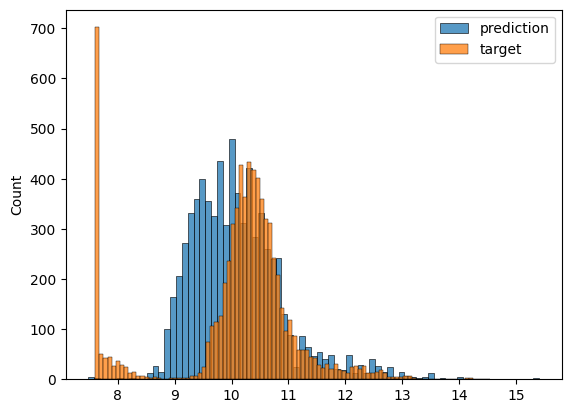

In [ ]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='target')
plt.legend()

In [ ]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

# RMSE Calculation

This function takes two vectors (y and y_pred) and calculates the RMSE, which is commonly used to evaluate regression models. The function calculates element-wise differences, squares them, averages them (MSE), and then takes the square root to get RMSE.

In [ ]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [ ]:
rmse(y_train, y_pred)

np.float64(0.7554192603920132)

In [ ]:
df_num = df_val[base]
df_num = df_num.fillna(0)
X_val = df_num.values
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred)

np.float64(0.761653099130156)

In [ ]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [ ]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.761653099130156


# Generalizing the X-preparation Function

To avoid duplicating code when preparing both the training and validation feature matrices (X_train, X_val), we create a helper function prepare_X that handles the extraction and preprocessing of features.

In [ ]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    df['age'] = 2017 - df.year
    features.append('age')
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

# Training and Validation in One Block

With prepare_X in place, we simplify the training and validation process. We first prepare X_train and then train the model on it. After that, we apply the same model to the validation set X_val and calculate the RMSE to evaluate performance.

In [ ]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.5172055461058299


Comparing Predicted and Actual Distributions

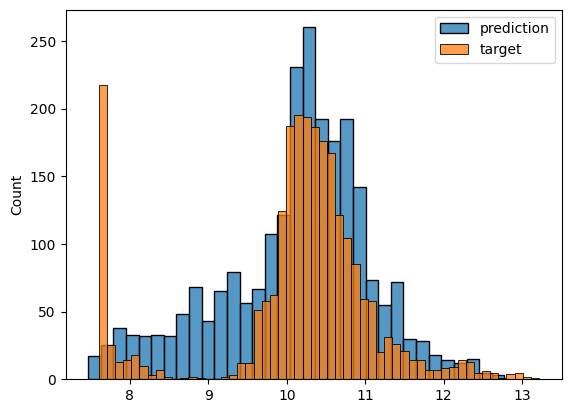

In [ ]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_val, label='target')
plt.legend()

In [ ]:
df['make'].value_counts().head(5)

,count
make,
chevrolet,1123
ford,881
volkswagen,809
toyota,746
dodge,626


# Modifying prepare_X to Include "Age"

We update the prepare_X function to include the age feature in the list of features used for model training. This function ensures consistency when preparing both the training and validation sets.

In [ ]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

# Re-testing with the "Age" Feature

After adding the age feature, we retrain the model and evaluate it on the validation set. The updated RMSE shows significant improvement, demonstrating that the new feature contributes useful information.

In [ ]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.5076038849556795


# Handling More Categorical Variables

Next, we extend our feature engineering to handle more categorical variables like engine_fuel_type, transmission_type, and others. The method remains the same: one-hot encoding for each distinct value of these categorical features.

In [ ]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)',
              'premium_unleaded_(recommended)',
              'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in ['front_wheel_drive', 'rear_wheel_drive',
              'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheels_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury',
              'luxury,performance', 'hatchback']:
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible',
              '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

# Final Model Evaluation (With New Features)

After adding the new features (e.g., fuel type, transmission), we test the model's performance again. However, as seen in the code, adding these features worsened the performance. This could be due to overfitting or numerical instability.

In [ ]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 71.37786410717939


# Linear Regression with Regularization

This is the function that implements regularized linear regression, also known as ridge regression. The r parameter controls the strength of regularization. A higher value of r results in more regularization, which shrinks the weights.

In [ ]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

# Evaluating the Impact of Regularization

We test different values of r to see how regularization affects the weights. As r increases, the weights should shrink, reducing the model's sensitivity to small changes in the input data.

In [ ]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[13], w[21]))

    0, 15838998853873358.00, -11.14, -15838998853873556.00
0.001, 7.20, -0.10, 1.81
 0.01, 7.18, -0.10, 1.81
  0.1, 7.05, -0.10, 1.78
    1, 6.22, -0.10, 1.56
   10, 4.39, -0.09, 1.08


# Testing RMSE with Regularization

we check the RMSE (Root Mean Squared Error) for different values of r to see how regularization affects the model's performance on the validation set. A lower RMSE indicates better performance.

In [ ]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.46022676273364194


# Fine-Tuning the Regularization Parameter

We experiment with various values of r to find the optimal regularization strength that minimizes the RMSE on the validation set. This helps to identify the best model configuration.

In [ ]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

 1e-06 0.46022548424788495
0.0001 0.4602254932133925
 0.001 0.46022676273364194
  0.01 0.46023949636591693
   0.1 0.4603700695794901
     1 0.4618298042647429
     5 0.46840796275311086
    10 0.4757248100694009


# Model Evaluation on Test Data

After tuning the regularization parameter, we evaluate the model on the test set to check if it generalizes well to unseen data. The performance on the test set should be similar to that on the validation set.

In [ ]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.46023949636591693
test: 0.4571813679733763


# Using the Model for Prediction

Once the model is trained and evaluated, we can use it to make predictions for new car data. This example shows how to predict the price for a new car based on a user's input ad.

In [ ]:
ad = {
    'city_mpg': 18,
    'driven_wheels': 'all_wheel_drive',
    'engine_cylinders': 6.0,
    'engine_fuel_type': 'regular_unleaded',
    'engine_hp': 268.0,
    'highway_mpg': 25,
    'make': 'toyota',
    'market_category': 'crossover,performance',
    'model': 'venza',
    'number_of_doors': 4.0,
    'popularity': 2031,
    'transmission_type': 'automatic',
    'vehicle_size': 'midsize',
    'vehicle_style': 'wagon',
    'year': 2013
}

In [ ]:
df_test = pd.DataFrame([ad])
X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
suggestion = np.expm1(y_pred)

In [ ]:
print(suggestion)

[28294.13592896]
